In [1]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import seaborn as sns
import random
%matplotlib inline 

In [2]:
# to see all the columns when using head() or describe()
pd.set_option('display.max_columns',60)

In [3]:
# df = pd.read_csv("kenya_data/diaries_transactions_all.csv", dtype={'account_startclose_balance': str})

In [4]:
df = pd.read_csv("../diaries_transactions_all.csv", dtype={'account_startclose_balance': str})

## For now I keep only "business and agriculture loans", "joint liability loans", "personal loans", "borrowing from an informal group", "borrowing from family and friends", "shylock loans".

In [5]:
dfb = df[((df["trx_family_code"]=="FRMLN")&((df["trx_type_code"]==2760)|(df["trx_type_code"]==3247)|(df["trx_type_code"]==2762)))|((df["trx_family_code"]=="INFGRP")&(df["trx_type_code"]==3395))]

# 1. Get rid of loans of with unexplained balance adjustments

In [6]:
dfb["trx_prx_purpose"].unique()

array(['7. Closing Balance--End of last DQ',
       '6. Closing Balance--End of last DQ',
       '1. Starting balance (today)', '5. Interest accruing',
       'DECREASE--Unexplained balance adjustment',
       'INCREASE--Unexplained balance adjustment', '3. Payments',
       '4. Any known fees', '2. New borrowinng (individual portion)',
       '2. New borrowing', '7. Refund from lender'], dtype=object)

We insert a new column that is 0 if there is no unexplained balance adjustment for this account and a 1 if there is one. The column in 1 or 0 for all entries that correspond to that account.

In [7]:
dfb.insert(dfb.shape[1], "acc_unexplained_trx", np.zeros(dfb.shape[0]))

This program goes through all unique accounts, checks whether it has an unexplained balance adjustment and if yes sets the variable u to 1. Then it goes through another for-loop and sets the entries of that column 0 for all accounts that have an unexplained balance adjustment.

In [8]:
for acc in dfb["account_ids"].unique():
    u = 0
    for index,row in dfb[dfb["account_ids"]==acc].iterrows():
        if row["trx_prx_purpose"]=="DECREASE--Unexplained balance adjustment" or row["trx_prx_purpose"]=="INCREASE--Unexplained balance adjustment":
            u = 1
    for index,row in dfb[dfb["account_ids"]==acc].iterrows():
        dfb.at[index,"acc_unexplained_trx"] = u

### Let us check if it worked.

In [9]:
s = set()
for acc in dfb[dfb["acc_unexplained_trx"]==0]["account_ids"].unique():
     for i in dfb[dfb["account_ids"]==acc]["trx_prx_purpose"].unique():
            s.add(i)
print(s)

{'4. Any known fees', '3. Payments', '2. New borrowing', '7. Closing Balance--End of last DQ', '5. Interest accruing', '2. New borrowinng (individual portion)', '7. Refund from lender', '6. Closing Balance--End of last DQ', '1. Starting balance (today)'}


### "refund from lender" might be hard to deal with, but there are only 2 of those

In [10]:
dfb[dfb["trx_prx_purpose"]=="7. Refund from lender"]

,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,trx_year,trx_yr_mo,trx_dq_round,trx_stdtime_days_hh,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_stdtime_mnths_hh_nr,acc_unexplained_trx
38535,KVIHC30,NaN,14aug2012,25sep2013,407,14,06=Cleaning interview,24sep2013,9,2013,2013_09,12sep2012,59136376033300000,NaN,59134381215900000,NaN,Liability,NaN,Formal,NaN,15jan2013,23sep2013,251,8,34138708620100000,59134381215900000,01aug2013,8,2013,2013_08,19.0,352,12,198,6,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,7. Refund from lender,NaN,0.0,NaN,10.0,"In-kind (trade, good, service--NOT MONEY)",1.0,0.0,07=Group meeting,Inflow,300.0,3.529412,0,panga,3.529412,300.0,12.137930,0.0
177005,KVIHC13,NaN,08sep2012,30sep2013,387,13,06=Cleaning interview,27sep2013,9,2013,2013_09,29aug2012,59135288408400000,NaN,HH,NaN,Liability,NaN,Formal,NaN,20dec2012,30sep2013,284,9,60138608712700000,59134372493300000,16apr2013,4,2013,2013_04,20.0,220,7,117,4,findev,"Borrowing, lending, savings or insurance media...",FRMLN,Formal loan,2760,Individual Business or Agriculture Loan,7. Refund from lender,NaN,0.0,NaN,1.0,Cash,1.0,0.0,07=Group meeting,Inflow,200.0,2.352941,0,NaN,NaN,NaN,7.586207,1.0


# Let's now only use the loans that have no unexplained balance adjustments.

In [11]:
dfb = dfb[dfb["acc_unexplained_trx"]==0]

# 2. Truncation into chunks with no new borrowing

We first insert a column for the new account numbers. These will be like the old account numbers but with a .1 or .2 for each chunk after a new borrowing.

In [12]:
# this is sometimes necessary if we mess smt up
# del dfb["new_account_ids"]

In [13]:
# add column for new account ids
dfb.insert(df.columns.get_loc("account_ids")+1,"new_account_ids", ["-"]*(dfb.shape[0]))

In [14]:
#add balance evolution to original dataset
df.insert(df.shape[1],"bal_evol",np.zeros(df.shape[0]))

In [15]:
#add column for starting balance 
df.insert(df.shape[1],"start_bal",np.zeros(df.shape[0]))

### Now let's adjust this such that new borrowings are always the first thing on one day, and then run the program that truncates into chunks with new borrowings.

In [16]:
exc=set()
accounts = []
for acc in dfb["account_ids"].unique():
    accounts.append(acc)
    i=0
    # we will use "indices" to save the reordered indices of the dataset for each unique loan
    indices = []
    # we will use "index_bor" to save the index of the new borrowing that happens on a given day,
    #whenever there were also other transactions (since we need that index to be first)
    index_bor = 0
    #only keep the rows of that account
    lna = dfb[dfb["account_ids"]==acc]
    # sort the dataset according to time
    lna = lna.sort_values("trx_stdtime_days_acc")
    # for each day in the dataset of the account, we check whether there was 
    # a new borrowing or starting balance and if yes reorder
    for d in lna["trx_stdtime_days_acc"].unique():
        # if only one entry that day we just add the index to indices
        if lna[lna["trx_stdtime_days_acc"]==d].shape[0]==1:
            indices.append(lna[lna["trx_stdtime_days_acc"]==d].index[0])
        # if there are more than 1 entry that day
        elif lna[lna["trx_stdtime_days_acc"]==d].shape[0]>1:
            # if there are more than one new borrowings or starting balances, we need to check manually
            if lna[(lna["trx_stdtime_days_acc"]==d)&((lna["trx_prx_purpose"]=="2. New borrowing")|(lna["trx_prx_purpose"]=="2. New borrowinng (individual portion)")|(lna["trx_prx_purpose"]=="1. Starting balance (today)"))].shape[0]>1:
                print("Several new borrowings on day " + str(d) +", check manually account " + acc + " in category "+ str(lna["trx_type_code"].unique()))
                for i in lna[lna["trx_stdtime_days_acc"]==d].index:
                            indices.append(i)
            #if there is exactly one new borrowing or starting balance that day (here we will need to check for each loan type what they exactly call new borrowings)
            elif lna[(lna["trx_stdtime_days_acc"]==d)&((lna["trx_prx_purpose"]=="2. New borrowing")|(lna["trx_prx_purpose"]=="2. New borrowinng (individual portion)")|(lna["trx_prx_purpose"]=="1. Starting balance (today)"))].shape[0]==1:
                #for each type of new borrowing if there is one that day, put that index first into indices
                for kind in ["2. New borrowing","2. New borrowinng (individual portion)","1. Starting balance (today)"]:
                    if kind in lna[lna["trx_stdtime_days_acc"]==d]["trx_prx_purpose"].unique():
                        index_bor = lna[(lna["trx_stdtime_days_acc"]==d) & (lna["trx_prx_purpose"]==kind)].index[0]
                        indices.append(index_bor)
                        #then add all other indices of that day
                        for i in lna[lna["trx_stdtime_days_acc"]==d].index.drop(index_bor):
                            indices.append(i)
            # if there are several entries for that day but none of them new borrowings just add all indices of that day            
            else:
                for i in lna[lna["trx_stdtime_days_acc"]==d].index:
                    indices.append(i)
    # here we reindex the lna dataset, so that each day the new borrowing is first
    lna = lna.loc[indices,]
    
    #add transaction with direction for account
    lna.insert(58, "trx_val_dir",np.zeros(lna.shape[0]))
    for index, row in lna.iterrows():
        if lna.loc[index,"trx_bsheet_direction"]=="Increase":
            lna.at[index,"trx_val_dir"] = lna.loc[index,"trx_value_kes"]
        elif lna.loc[index,"trx_bsheet_direction"]=="Decrease":
            lna.at[index,"trx_val_dir"] = -lna.loc[index,"trx_value_kes"]
        else:
            #save where there is neither increase nor decrease
            exc.add(row["trx_prx_purpose"])
    
    #add the balance evolution entries to df 
    s=0
    for index,row in lna.iterrows():
        s+=lna.loc[index,"trx_val_dir"]
        dfb.at[index,"bal_evol"]=s
    
    #truncating into chunks between new borrowings
    #v will be the index of the chunk we are currently at
    v=0
    # saving the old account number
    acc = lna["account_ids"].unique()[0]
    # a is the new account number for each chunk
    a = lna["account_ids"].unique()[0]+".0"
    #saving all account numbers we used
    accs = set()
    # we go through all rows of lna and change the entries of the column "new_account_ids" in the original dataset.
    for index, row in lna.iterrows():
        # if there is a new borrowing in the row, increase v by 1 and set a to acc.v
        if row["trx_prx_purpose"] == "1. Starting balance (today)" or row["trx_prx_purpose"] == "2. New borrowinng (individual portion)" or row["trx_prx_purpose"] == "2. New borrowing":
            v +=1
            a = acc+"."+str(v)
            dfb.at[index,"new_account_ids"]=a
            lna.at[index,"new_account_ids"]=a
            accs.add(a)
        # otherwise set the new account number in that row to a
        else:
            dfb.at[index,"new_account_ids"]=a
            lna.at[index,"new_account_ids"]=a
            accs.add(a)
            
    # adding starting balance to each new account
    # for each new account
    for a in accs:
        # restrict lna further to only that chunk
        lnaa = lna[lna["new_account_ids"]==a]
        #the starting balance is the first balance of that chunk
        st_bal = dfb.loc[lnaa.index[0],"bal_evol"]
        # assign that starting balance into each row corresponding to this accoun chunk
        for index in lnaa.index:
            dfb.at[index,"start_bal"]=st_bal
        

Several new borrowings on day 244, check manually account 61135946960100000 in category [3395]


Several borrowings on the same day.

61135946960100000


In [17]:
dfb[dfb["account_ids"]=="61135946960100000"].sort_values("trx_stdtime_days_acc")[["account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","trx_bsheet_direction","bal_evol","start_bal"]]

,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,trx_bsheet_direction,bal_evol,start_bal
118905,61135946960100000,61135946960100000.1,0,2. New borrowing,500.0,Increase,500.0,500.0
195059,61135946960100000,61135946960100000.1,5,3. Payments,500.0,Decrease,0.0,500.0
43429,61135946960100000,61135946960100000.2,141,2. New borrowing,2000.0,Increase,2000.0,2000.0
212855,61135946960100000,61135946960100000.3,244,2. New borrowing,1300.0,Increase,3300.0,3300.0
295268,61135946960100000,61135946960100000.4,244,2. New borrowing,500.0,Increase,3800.0,3800.0
5052,61135946960100000,61135946960100000.4,285,7. Closing Balance--End of last DQ,3800.0,NaN,3800.0,3800.0


The account 61135946960100000 seems to have several new borrowings on day 244.

With our new system we can still keep it.

## Let's check if it worked.

Let's see if all accounts got a new name.

In [18]:
dfb[dfb["new_account_ids"]=="-"]

,hh_ids,unique_hhs,first_trx_date_hh,last_trx_date_hh,tot_hh_daysofobs,tot_hh_monthsofobs,interview_designation,int_date,int_month,int_year,int_yr_mo,first_int_date,account_ids,new_account_ids,unique_accnts,m_ids_owner,unique_hm_owner,account_bsheet_desig,account_startclose_balance,account_formal,account_liquid,first_trx_date_acc,last_trx_date_acc,tot_acc_daysofobs,tot_acc_monthsofobs,trx_id,m_ids_trx,trx_date,trx_month,trx_year,...,trx_stdtime_days_hh,trx_stdtime_mnths_hh,trx_stdtime_days_acc,trx_stdtime_mnths_acc,trx_class_code,trx_class_desc,trx_family_code,trx_family_desc,trx_type_code,trx_type_desc,trx_prx_purpose,trx_prx_purpose_fd,trx_fee,trx_bsheet_direction,trx_mode_code,trx_mode_desc,trx_place_incommunity,trx_distance_km,trx_outlet,trx_direction,trx_value_kes,trx_value_usd,ddd_gift,trx_inkind_units,trx_inkind_value_usd,trx_inkind_value_kes,trx_stdtime_mnths_hh_nr,acc_unexplained_trx,bal_evol,start_bal


## Let's look at a few accounts to see if there are bugs.

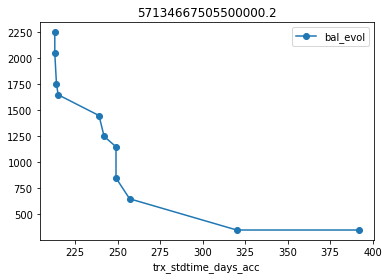

57134667505500000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
3680,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,213,5. Interest accruing,200.0,2250.0,2050.0
289254,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,213,2. New borrowing,2000.0,2050.0,2050.0
310352,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,214,3. Payments,500.0,1750.0,2050.0
168649,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,215,3. Payments,100.0,1650.0,2050.0
415297,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,239,3. Payments,200.0,1450.0,2050.0
294033,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,242,3. Payments,200.0,1250.0,2050.0
2897,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,249,3. Payments,100.0,1150.0,2050.0
185787,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,249,3. Payments,300.0,850.0,2050.0
161739,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,257,3. Payments,200.0,650.0,2050.0
311316,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,320,3. Payments,300.0,350.0,2050.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
22815,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.1,0,1. Starting balance (today),550.0,550.0,550.0
133434,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.1,3,3. Payments,500.0,50.0,550.0
3680,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,213,5. Interest accruing,200.0,2250.0,2050.0
289254,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,213,2. New borrowing,2000.0,2050.0,2050.0
310352,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,214,3. Payments,500.0,1750.0,2050.0
168649,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,215,3. Payments,100.0,1650.0,2050.0
415297,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,239,3. Payments,200.0,1450.0,2050.0
294033,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,242,3. Payments,200.0,1250.0,2050.0
2897,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,249,3. Payments,100.0,1150.0,2050.0
185787,INFGRP,Borrowing from an informal Group,57134667505500000,57134667505500000.2,249,3. Payments,300.0,850.0,2050.0


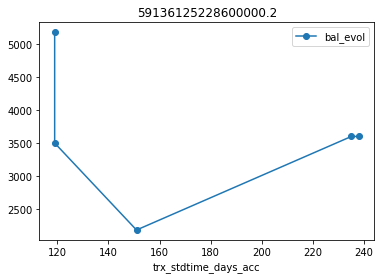

59136125228600000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
18747,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,119,5. Interest accruing,1680.0,5180.0,3500.0
302596,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,119,2. New borrowing,1000.0,3500.0,3500.0
305629,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,151,3. Payments,3000.0,2180.0,3500.0
15901,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,235,5. Interest accruing,1420.0,3600.0,3500.0
18075,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,238,7. Closing Balance--End of last DQ,3600.0,3600.0,3500.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
126109,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.1,0,2. New borrowing,3000.0,3000.0,3000.0
444145,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.1,63,3. Payments,500.0,2500.0,3000.0
18747,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,119,5. Interest accruing,1680.0,5180.0,3500.0
302596,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,119,2. New borrowing,1000.0,3500.0,3500.0
305629,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,151,3. Payments,3000.0,2180.0,3500.0
15901,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,235,5. Interest accruing,1420.0,3600.0,3500.0
18075,INFGRP,Borrowing from an informal Group,59136125228600000,59136125228600000.2,238,7. Closing Balance--End of last DQ,3600.0,3600.0,3500.0


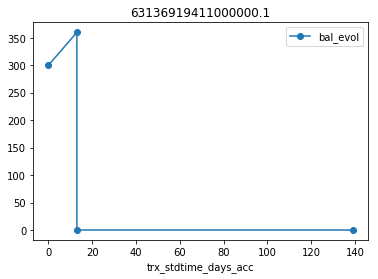

63136919411000000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
419721,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,0,2. New borrowing,300.0,300.0,300.0
8085,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,13,5. Interest accruing,60.0,360.0,300.0
118311,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,13,3. Payments,360.0,0.0,300.0
6554,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,139,7. Closing Balance--End of last DQ,0.0,0.0,300.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
419721,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,0,2. New borrowing,300.0,300.0,300.0
8085,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,13,5. Interest accruing,60.0,360.0,300.0
118311,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,13,3. Payments,360.0,0.0,300.0
6554,INFGRP,Borrowing from an informal Group,63136919411000000,63136919411000000.1,139,7. Closing Balance--End of last DQ,0.0,0.0,300.0


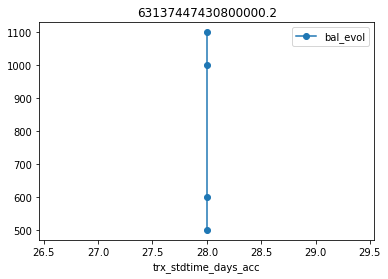

63137447430800000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
25767,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,5. Interest accruing,100.0,1100.0,1000.0
66841,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,2. New borrowing,500.0,1000.0,1000.0
132235,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,3. Payments,500.0,600.0,1000.0
380651,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,3. Payments,100.0,500.0,1000.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
8110,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.1,0,4. Any known fees,100.0,600.0,500.0
153005,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.1,0,2. New borrowing,500.0,500.0,500.0
232865,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.1,0,3. Payments,100.0,500.0,500.0
25767,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,5. Interest accruing,100.0,1100.0,1000.0
66841,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,2. New borrowing,500.0,1000.0,1000.0
132235,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,3. Payments,500.0,600.0,1000.0
380651,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.2,28,3. Payments,100.0,500.0,1000.0
46049,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.3,63,3. Payments,100.0,1000.0,1100.0
281280,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.3,63,3. Payments,500.0,500.0,1100.0
380656,INFGRP,Borrowing from an informal Group,63137447430800000,63137447430800000.3,63,2. New borrowing,600.0,1100.0,1100.0


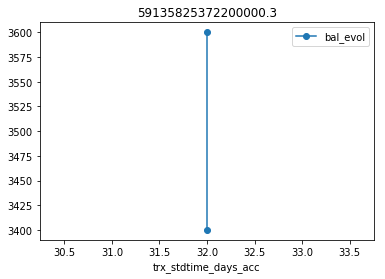

59135825372200000.3


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
3936,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.3,32,5. Interest accruing,200.0,3600.0,3400.0
443210,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.3,32,2. New borrowing,1000.0,3400.0,3400.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
285092,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.1,0,2. New borrowing,1000.0,1000.0,1000.0
19868,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.1,0,5. Interest accruing,200.0,1200.0,1000.0
3935,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.2,9,5. Interest accruing,200.0,2400.0,2200.0
455577,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.2,9,2. New borrowing,1000.0,2200.0,2200.0
455585,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.2,9,3. Payments,200.0,2200.0,2200.0
18616,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.2,9,5. Interest accruing,200.0,2400.0,2200.0
3936,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.3,32,5. Interest accruing,200.0,3600.0,3400.0
443210,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.3,32,2. New borrowing,1000.0,3400.0,3400.0
84161,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.4,60,3. Payments,200.0,4400.0,4600.0
93310,INFGRP,Borrowing from an informal Group,59135825372200000,59135825372200000.4,60,3. Payments,1000.0,3400.0,4600.0


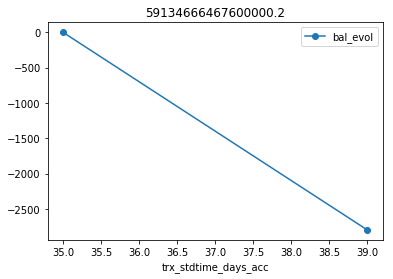

59134666467600000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
3263,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.2,35,1. Starting balance (today),0.0,0.0,0.0
347299,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.2,39,3. Payments,2800.0,-2800.0,0.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
2981,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.1,0,1. Starting balance (today),0.0,0.0,0.0
3263,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.2,35,1. Starting balance (today),0.0,0.0,0.0
347299,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.2,39,3. Payments,2800.0,-2800.0,0.0
177978,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.3,59,2. New borrowing,9625.0,6825.0,6825.0
259048,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.3,85,3. Payments,500.0,6325.0,6825.0
383852,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.3,106,3. Payments,300.0,6025.0,6825.0
275936,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.3,127,3. Payments,200.0,5825.0,6825.0
267186,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.3,134,3. Payments,500.0,5325.0,6825.0
61689,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.3,164,3. Payments,100.0,5225.0,6825.0
88092,FRMLN,Individual Business or Agriculture Loan,59134666467600000,59134666467600000.3,171,3. Payments,50.0,5175.0,6825.0


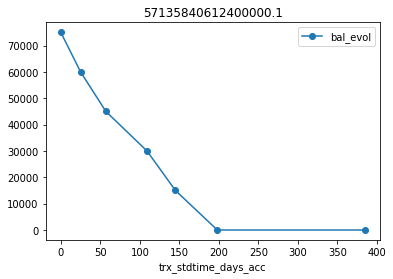

57135840612400000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
10695,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,0,1. Starting balance (today),75000.0,75000.0,75000.0
464457,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,25,3. Payments,15000.0,60000.0,75000.0
464213,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,57,3. Payments,15000.0,45000.0,75000.0
464242,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,109,3. Payments,15000.0,30000.0,75000.0
464302,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,145,3. Payments,15000.0,15000.0,75000.0
464294,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,198,3. Payments,15000.0,0.0,75000.0
19633,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,385,6. Closing Balance--End of last DQ,0.0,0.0,75000.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
10695,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,0,1. Starting balance (today),75000.0,75000.0,75000.0
464457,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,25,3. Payments,15000.0,60000.0,75000.0
464213,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,57,3. Payments,15000.0,45000.0,75000.0
464242,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,109,3. Payments,15000.0,30000.0,75000.0
464302,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,145,3. Payments,15000.0,15000.0,75000.0
464294,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,198,3. Payments,15000.0,0.0,75000.0
19633,FRMLN,Consumer/ personal loan (not payday loan),57135840612400000,57135840612400000.1,385,6. Closing Balance--End of last DQ,0.0,0.0,75000.0


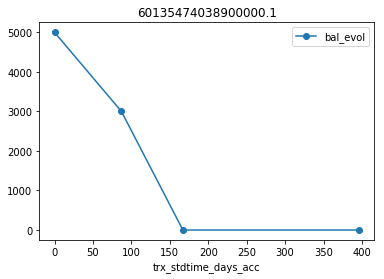

60135474038900000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
356651,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,0,1. Starting balance (today),5000.0,5000.0,5000.0
71397,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,87,3. Payments,2000.0,3000.0,5000.0
275327,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,167,3. Payments,3000.0,0.0,5000.0
12380,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,396,7. Closing Balance--End of last DQ,0.0,0.0,5000.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
356651,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,0,1. Starting balance (today),5000.0,5000.0,5000.0
71397,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,87,3. Payments,2000.0,3000.0,5000.0
275327,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,167,3. Payments,3000.0,0.0,5000.0
12380,INFGRP,Borrowing from an informal Group,60135474038900000,60135474038900000.1,396,7. Closing Balance--End of last DQ,0.0,0.0,5000.0


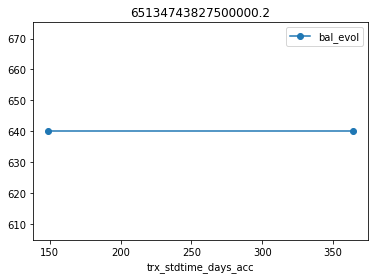

65134743827500000.2


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
89065,INFGRP,Borrowing from an informal Group,65134743827500000,65134743827500000.2,149,2. New borrowing,500.0,640.0,640.0
18114,INFGRP,Borrowing from an informal Group,65134743827500000,65134743827500000.2,364,7. Closing Balance--End of last DQ,640.0,640.0,640.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
24825,INFGRP,Borrowing from an informal Group,65134743827500000,65134743827500000.1,0,1. Starting balance (today),440.0,440.0,440.0
392691,INFGRP,Borrowing from an informal Group,65134743827500000,65134743827500000.1,47,3. Payments,300.0,140.0,440.0
89065,INFGRP,Borrowing from an informal Group,65134743827500000,65134743827500000.2,149,2. New borrowing,500.0,640.0,640.0
18114,INFGRP,Borrowing from an informal Group,65134743827500000,65134743827500000.2,364,7. Closing Balance--End of last DQ,640.0,640.0,640.0


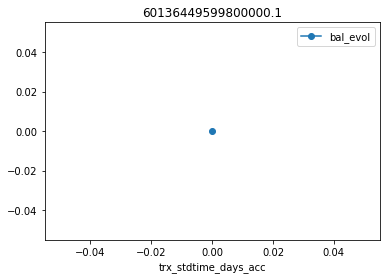

60136449599800000.1


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
21557,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.1,0,1. Starting balance (today),0.0,0.0,0.0


,trx_family_code,trx_type_desc,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal
21557,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.1,0,1. Starting balance (today),0.0,0.0,0.0
3956,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.2,174,5. Interest accruing,200.0,1200.0,1000.0
150382,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.2,174,2. New borrowing,1000.0,1000.0,1000.0
322186,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.2,174,3. Payments,200.0,1000.0,1000.0
25501,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.2,234,5. Interest accruing,200.0,1200.0,1000.0
280128,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.2,234,3. Payments,500.0,700.0,1000.0
23902,INFGRP,Borrowing from an informal Group,60136449599800000,60136449599800000.2,380,7. Closing Balance--End of last DQ,700.0,700.0,1000.0


In [19]:
for i in range(0,10):
    acc=random.choice(dfb["new_account_ids"].unique())
    dfb[dfb["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc").plot(x="trx_stdtime_days_acc",y="bal_evol", title = acc,marker="o")
    plt.show()
    print(acc)
    display(dfb[dfb["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])
    display(dfb[dfb["account_ids"]==acc[:-2]].sort_values("trx_stdtime_days_acc")[["trx_family_code","trx_type_desc","account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal"]])

# Add observation length

In [20]:
dfb.insert(dfb.shape[1],"obs_length",np.zeros(dfb.shape[0]))

In [21]:
for acc in dfb["new_account_ids"].unique():
    lna = dfb[dfb["new_account_ids"]==acc]
    days = lna["trx_stdtime_days_acc"].unique()
    l = days.max() - days.min()
    for index, row in dfb[dfb["new_account_ids"]==acc].iterrows():
        dfb.at[index,"obs_length"] = l

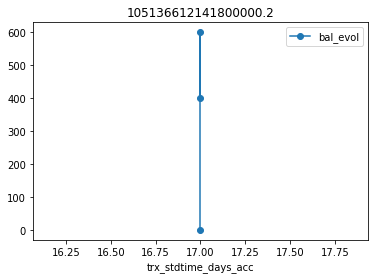

105136612141800000.2


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
125090,105136612141800000,105136612141800000.2,17,3. Payments,400.0,0.0,600.0,0.0
200859,105136612141800000,105136612141800000.2,17,2. New borrowing,600.0,600.0,600.0,0.0
213713,105136612141800000,105136612141800000.2,17,3. Payments,200.0,400.0,600.0,0.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
215247,105136612141800000,105136612141800000.1,0,2. New borrowing,6000.0,6000.0,6000.0,10.0
104863,105136612141800000,105136612141800000.1,10,5. Interest accruing,600.0,6600.0,6000.0,10.0
214054,105136612141800000,105136612141800000.1,10,3. Payments,6600.0,0.0,6000.0,10.0
213713,105136612141800000,105136612141800000.2,17,3. Payments,200.0,400.0,600.0,0.0
125090,105136612141800000,105136612141800000.2,17,3. Payments,400.0,0.0,600.0,0.0
200859,105136612141800000,105136612141800000.2,17,2. New borrowing,600.0,600.0,600.0,0.0
80496,105136612141800000,105136612141800000.3,32,3. Payments,1700.0,0.0,1700.0,0.0
102729,105136612141800000,105136612141800000.3,32,2. New borrowing,1700.0,1700.0,1700.0,0.0
342224,105136612141800000,105136612141800000.4,75,3. Payments,300.0,1700.0,2000.0,0.0
89511,105136612141800000,105136612141800000.4,75,3. Payments,1700.0,0.0,2000.0,0.0


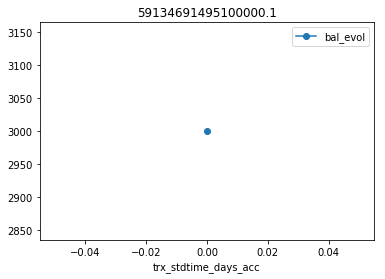

59134691495100000.1


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
24559,59134691495100000,59134691495100000.1,0,1. Starting balance (today),3000.0,3000.0,3000.0,0.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
24559,59134691495100000,59134691495100000.1,0,1. Starting balance (today),3000.0,3000.0,3000.0,0.0
4824,59134691495100000,59134691495100000.2,47,5. Interest accruing,1200.0,10200.0,9000.0,71.0
17353,59134691495100000,59134691495100000.2,47,1. Starting balance (today),6000.0,9000.0,9000.0,71.0
3320,59134691495100000,59134691495100000.2,78,5. Interest accruing,1200.0,11400.0,9000.0,71.0
246293,59134691495100000,59134691495100000.2,96,3. Payments,3000.0,8400.0,9000.0,71.0
2399,59134691495100000,59134691495100000.2,108,5. Interest accruing,600.0,9000.0,9000.0,71.0
37796,59134691495100000,59134691495100000.2,118,3. Payments,7000.0,2000.0,9000.0,71.0
246298,59134691495100000,59134691495100000.3,132,2. New borrowing,1000.0,3000.0,3000.0,0.0
159921,59134691495100000,59134691495100000.3,132,3. Payments,200.0,2800.0,3000.0,0.0
5212,59134691495100000,59134691495100000.3,132,5. Interest accruing,200.0,3000.0,3000.0,0.0


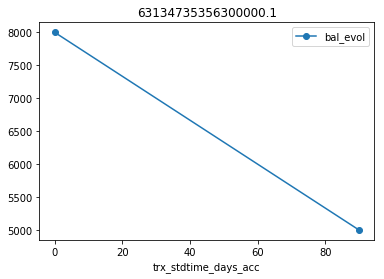

63134735356300000.1


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
22152,63134735356300000,63134735356300000.1,0,1. Starting balance (today),8000.0,8000.0,8000.0,90.0
228788,63134735356300000,63134735356300000.1,90,3. Payments,3000.0,5000.0,8000.0,90.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
22152,63134735356300000,63134735356300000.1,0,1. Starting balance (today),8000.0,8000.0,8000.0,90.0
228788,63134735356300000,63134735356300000.1,90,3. Payments,3000.0,5000.0,8000.0,90.0


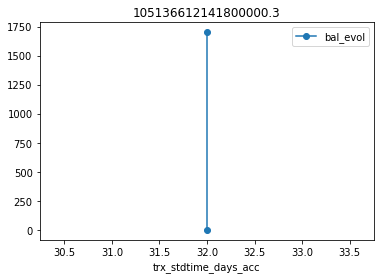

105136612141800000.3


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
80496,105136612141800000,105136612141800000.3,32,3. Payments,1700.0,0.0,1700.0,0.0
102729,105136612141800000,105136612141800000.3,32,2. New borrowing,1700.0,1700.0,1700.0,0.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
215247,105136612141800000,105136612141800000.1,0,2. New borrowing,6000.0,6000.0,6000.0,10.0
104863,105136612141800000,105136612141800000.1,10,5. Interest accruing,600.0,6600.0,6000.0,10.0
214054,105136612141800000,105136612141800000.1,10,3. Payments,6600.0,0.0,6000.0,10.0
213713,105136612141800000,105136612141800000.2,17,3. Payments,200.0,400.0,600.0,0.0
125090,105136612141800000,105136612141800000.2,17,3. Payments,400.0,0.0,600.0,0.0
200859,105136612141800000,105136612141800000.2,17,2. New borrowing,600.0,600.0,600.0,0.0
80496,105136612141800000,105136612141800000.3,32,3. Payments,1700.0,0.0,1700.0,0.0
102729,105136612141800000,105136612141800000.3,32,2. New borrowing,1700.0,1700.0,1700.0,0.0
342224,105136612141800000,105136612141800000.4,75,3. Payments,300.0,1700.0,2000.0,0.0
89511,105136612141800000,105136612141800000.4,75,3. Payments,1700.0,0.0,2000.0,0.0


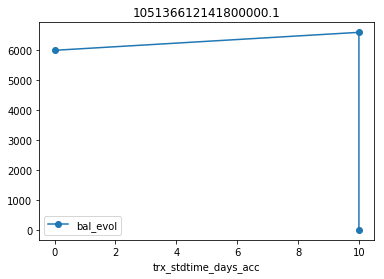

105136612141800000.1


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
215247,105136612141800000,105136612141800000.1,0,2. New borrowing,6000.0,6000.0,6000.0,10.0
104863,105136612141800000,105136612141800000.1,10,5. Interest accruing,600.0,6600.0,6000.0,10.0
214054,105136612141800000,105136612141800000.1,10,3. Payments,6600.0,0.0,6000.0,10.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
215247,105136612141800000,105136612141800000.1,0,2. New borrowing,6000.0,6000.0,6000.0,10.0
104863,105136612141800000,105136612141800000.1,10,5. Interest accruing,600.0,6600.0,6000.0,10.0
214054,105136612141800000,105136612141800000.1,10,3. Payments,6600.0,0.0,6000.0,10.0
213713,105136612141800000,105136612141800000.2,17,3. Payments,200.0,400.0,600.0,0.0
125090,105136612141800000,105136612141800000.2,17,3. Payments,400.0,0.0,600.0,0.0
200859,105136612141800000,105136612141800000.2,17,2. New borrowing,600.0,600.0,600.0,0.0
80496,105136612141800000,105136612141800000.3,32,3. Payments,1700.0,0.0,1700.0,0.0
102729,105136612141800000,105136612141800000.3,32,2. New borrowing,1700.0,1700.0,1700.0,0.0
342224,105136612141800000,105136612141800000.4,75,3. Payments,300.0,1700.0,2000.0,0.0
89511,105136612141800000,105136612141800000.4,75,3. Payments,1700.0,0.0,2000.0,0.0


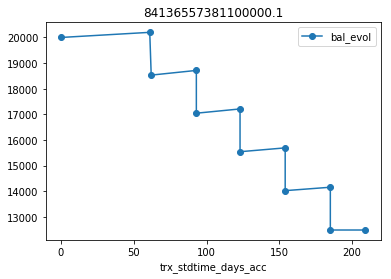

84136557381100000.1


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
417999,84136557381100000,84136557381100000.1,0,2. New borrowing,20000.0,20000.0,20000.0,209.0
2019,84136557381100000,84136557381100000.1,61,5. Interest accruing,200.0,20200.0,20000.0,209.0
92839,84136557381100000,84136557381100000.1,62,3. Payments,1668.0,18532.0,20000.0,209.0
15149,84136557381100000,84136557381100000.1,93,5. Interest accruing,183.0,18715.0,20000.0,209.0
419232,84136557381100000,84136557381100000.1,93,3. Payments,1668.0,17047.0,20000.0,209.0
20069,84136557381100000,84136557381100000.1,123,5. Interest accruing,166.0,17213.0,20000.0,209.0
316159,84136557381100000,84136557381100000.1,123,3. Payments,1668.0,15545.0,20000.0,209.0
17413,84136557381100000,84136557381100000.1,154,5. Interest accruing,150.0,15695.0,20000.0,209.0
323947,84136557381100000,84136557381100000.1,154,3. Payments,1668.0,14027.0,20000.0,209.0
8305,84136557381100000,84136557381100000.1,185,5. Interest accruing,133.0,14160.0,20000.0,209.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
417999,84136557381100000,84136557381100000.1,0,2. New borrowing,20000.0,20000.0,20000.0,209.0
2019,84136557381100000,84136557381100000.1,61,5. Interest accruing,200.0,20200.0,20000.0,209.0
92839,84136557381100000,84136557381100000.1,62,3. Payments,1668.0,18532.0,20000.0,209.0
15149,84136557381100000,84136557381100000.1,93,5. Interest accruing,183.0,18715.0,20000.0,209.0
419232,84136557381100000,84136557381100000.1,93,3. Payments,1668.0,17047.0,20000.0,209.0
20069,84136557381100000,84136557381100000.1,123,5. Interest accruing,166.0,17213.0,20000.0,209.0
316159,84136557381100000,84136557381100000.1,123,3. Payments,1668.0,15545.0,20000.0,209.0
17413,84136557381100000,84136557381100000.1,154,5. Interest accruing,150.0,15695.0,20000.0,209.0
323947,84136557381100000,84136557381100000.1,154,3. Payments,1668.0,14027.0,20000.0,209.0
8305,84136557381100000,84136557381100000.1,185,5. Interest accruing,133.0,14160.0,20000.0,209.0


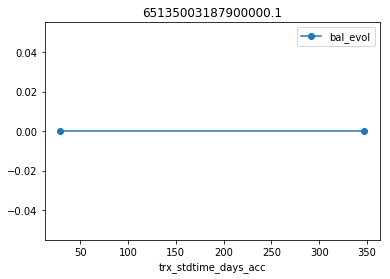

65135003187900000.1


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
14557,65135003187900000,65135003187900000.1,29,2. New borrowing,2000.0,0.0,0.0,318.0
9981,65135003187900000,65135003187900000.1,347,7. Closing Balance--End of last DQ,0.0,0.0,0.0,318.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
388558,65135003187900000,65135003187900000.0,0,3. Payments,2000.0,-2000.0,-2000.0,0.0
14557,65135003187900000,65135003187900000.1,29,2. New borrowing,2000.0,0.0,0.0,318.0
9981,65135003187900000,65135003187900000.1,347,7. Closing Balance--End of last DQ,0.0,0.0,0.0,318.0


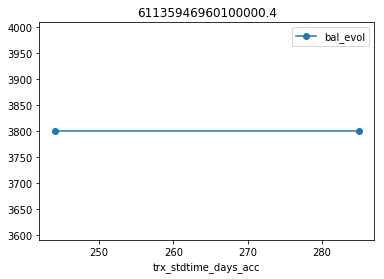

61135946960100000.4


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
295268,61135946960100000,61135946960100000.4,244,2. New borrowing,500.0,3800.0,3800.0,41.0
5052,61135946960100000,61135946960100000.4,285,7. Closing Balance--End of last DQ,3800.0,3800.0,3800.0,41.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
118905,61135946960100000,61135946960100000.1,0,2. New borrowing,500.0,500.0,500.0,5.0
195059,61135946960100000,61135946960100000.1,5,3. Payments,500.0,0.0,500.0,5.0
43429,61135946960100000,61135946960100000.2,141,2. New borrowing,2000.0,2000.0,2000.0,0.0
212855,61135946960100000,61135946960100000.3,244,2. New borrowing,1300.0,3300.0,3300.0,0.0
295268,61135946960100000,61135946960100000.4,244,2. New borrowing,500.0,3800.0,3800.0,41.0
5052,61135946960100000,61135946960100000.4,285,7. Closing Balance--End of last DQ,3800.0,3800.0,3800.0,41.0


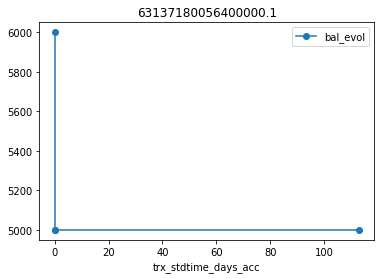

63137180056400000.1


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
15512,63137180056400000,63137180056400000.1,0,5. Interest accruing,1000.0,6000.0,5000.0,113.0
39571,63137180056400000,63137180056400000.1,0,3. Payments,1000.0,5000.0,5000.0,113.0
229178,63137180056400000,63137180056400000.1,0,2. New borrowing,5000.0,5000.0,5000.0,113.0
4280,63137180056400000,63137180056400000.1,113,7. Closing Balance--End of last DQ,5000.0,5000.0,5000.0,113.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
15512,63137180056400000,63137180056400000.1,0,5. Interest accruing,1000.0,6000.0,5000.0,113.0
39571,63137180056400000,63137180056400000.1,0,3. Payments,1000.0,5000.0,5000.0,113.0
229178,63137180056400000,63137180056400000.1,0,2. New borrowing,5000.0,5000.0,5000.0,113.0
4280,63137180056400000,63137180056400000.1,113,7. Closing Balance--End of last DQ,5000.0,5000.0,5000.0,113.0


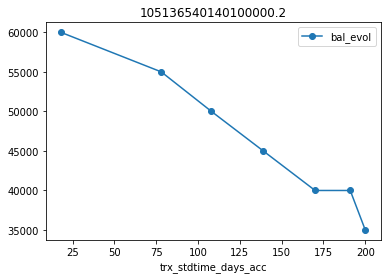

105136540140100000.2


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
433509,105136540140100000,105136540140100000.2,18,2. New borrowing,60000.0,60000.0,60000.0,182.0
461323,105136540140100000,105136540140100000.2,78,3. Payments,5000.0,55000.0,60000.0,182.0
461250,105136540140100000,105136540140100000.2,108,3. Payments,5000.0,50000.0,60000.0,182.0
461229,105136540140100000,105136540140100000.2,139,3. Payments,5000.0,45000.0,60000.0,182.0
461273,105136540140100000,105136540140100000.2,170,3. Payments,5000.0,40000.0,60000.0,182.0
19299,105136540140100000,105136540140100000.2,191,6. Closing Balance--End of last DQ,35000.0,40000.0,60000.0,182.0
461242,105136540140100000,105136540140100000.2,200,3. Payments,5000.0,35000.0,60000.0,182.0


,account_ids,new_account_ids,trx_stdtime_days_acc,trx_prx_purpose,trx_value_kes,bal_evol,start_bal,obs_length
162,105136540140100000,105136540140100000.1,0,1. Starting balance (today),18000.0,18000.0,18000.0,4.0
12134,105136540140100000,105136540140100000.1,4,3. Payments,18000.0,0.0,18000.0,4.0
433509,105136540140100000,105136540140100000.2,18,2. New borrowing,60000.0,60000.0,60000.0,182.0
461323,105136540140100000,105136540140100000.2,78,3. Payments,5000.0,55000.0,60000.0,182.0
461250,105136540140100000,105136540140100000.2,108,3. Payments,5000.0,50000.0,60000.0,182.0
461229,105136540140100000,105136540140100000.2,139,3. Payments,5000.0,45000.0,60000.0,182.0
461273,105136540140100000,105136540140100000.2,170,3. Payments,5000.0,40000.0,60000.0,182.0
19299,105136540140100000,105136540140100000.2,191,6. Closing Balance--End of last DQ,35000.0,40000.0,60000.0,182.0
461242,105136540140100000,105136540140100000.2,200,3. Payments,5000.0,35000.0,60000.0,182.0


In [22]:
for i in range(0,10):
    acc=random.choice(dfb["new_account_ids"].unique())
    dfb[dfb["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc").plot(x="trx_stdtime_days_acc",y="bal_evol", title = acc,marker="o")
    plt.show()
    print(acc)
    display(dfb[dfb["new_account_ids"]==acc].sort_values("trx_stdtime_days_acc")[["account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal","obs_length"]])
    display(dfb[dfb["account_ids"]==acc[:-2]].sort_values("trx_stdtime_days_acc")[["account_ids","new_account_ids","trx_stdtime_days_acc","trx_prx_purpose","trx_value_kes","bal_evol","start_bal","obs_length"]])

## Seems ok, let's now save this dataset

In [23]:
dfb = dfb[dfb["start_bal"]>10]

In [24]:
dfb.to_csv("diaries_trx_trunc_loans_start_bal.csv")

### Careful: the column "unique_accnts" is not accurate anymore.